In [4]:
# pacotes
import pandas as pd
# from datetime import datetime  # equivalente ao lubridate no R

# dados processados sobre absenteismo
df_absenteismo = pd.read_csv('absenteismo_processed.csv')

# dados processados sobre alertas no whatsapp
df_whatsapp = pd.read_csv('whatsapp_processed.csv')

In [5]:
display(df_absenteismo)

,periodo,hospital_padronizado,agendamentos,faltas,comparecimentos,taxa_absenteismo
0,2024 - 01,HOSPITAL JOSE MARTINIANO DE ALENCAR,380.0,200.0,180.0,52.631579
1,2024 - 02,HOSPITAL JOSE MARTINIANO DE ALENCAR,569.0,331.0,238.0,58.172232
2,2024 - 03,HOSPITAL JOSE MARTINIANO DE ALENCAR,690.0,457.0,233.0,66.231884
3,2024 - 04,HOSPITAL JOSE MARTINIANO DE ALENCAR,1001.0,537.0,464.0,53.646354
4,2024 - 05,HOSPITAL JOSE MARTINIANO DE ALENCAR,838.0,534.0,304.0,63.723150
...,...,...,...,...,...,...
209,2025 - 03,HOSPITAL UNIVERSITÁRIO DO CEARÁ,372.0,108.0,264.0,29.032258
210,2025 - 04,HOSPITAL UNIVERSITÁRIO DO CEARÁ,1825.0,463.0,1362.0,25.369863
211,2025 - 05,HOSPITAL UNIVERSITÁRIO DO CEARÁ,2770.0,459.0,2311.0,16.570397
212,2025 - 06,HOSPITAL UNIVERSITÁRIO DO CEARÁ,3223.0,505.0,2718.0,15.668632


In [6]:
display(df_whatsapp)

,date,hospital_padronizado,cidade,especialidade,tipo_alerta,count,year,month,day_of_week
0,2025-08-11,POLICLÍNICA BERNARDO FÉLIX DA SILVA,Sobral,ALERGIA E IMUNOLOGIA,Agendamentos,9,2025,8,Monday
1,2025-08-11,POLICLÍNICA BERNARDO FÉLIX DA SILVA,Sobral,ALERGIA E IMUNOLOGIA,Pré 10 dias,5,2025,8,Monday
2,2025-08-11,HOSPITAL DE MESSEJANA,Fortaleza,AMBULATORIO POS OPERATORIO,Agendamentos,20,2025,8,Monday
3,2025-08-11,HOSPITAL DE MESSEJANA,Fortaleza,AMBULATORIO POS OPERATORIO,Pré 2 dias,8,2025,8,Monday
4,2025-08-11,HOSPITAL ESTADUAL LEONARDO DA VINCI,Fortaleza,ANESTESIOLOGIA,Agendamentos,46,2025,8,Monday
...,...,...,...,...,...,...,...,...,...
26843,2025-03-26,HOSPITAL GERAL FORTALEZA,Fortaleza,USG ORTOPEDIA ESPORTE,Agendamentos,5,2025,3,Wednesday
26844,2025-03-26,HOSPITAL GERAL FORTALEZA,Fortaleza,USG ORTOPEDIA ESPORTE,Pré 2 dias,5,2025,3,Wednesday
26845,2025-03-26,HOSPITAL GERAL FORTALEZA,Fortaleza,VIGILANCIA PREMATUROS,Agendamentos,11,2025,3,Wednesday
26846,2025-03-31,HOSPITAL GERAL FORTALEZA,Fortaleza,VIGILANCIA PREMATUROS,Agendamentos,7,2025,3,Monday


AttributeError: module 'matplotlib.pyplot' has no attribute 'yla'

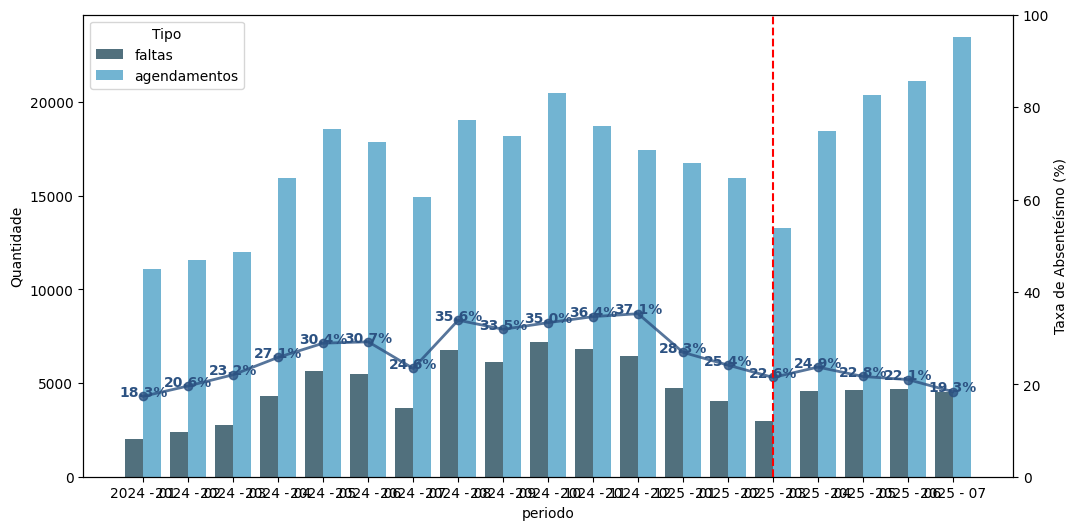

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# filtrar hospital, agrupar e calcular totais
df_totais = (
    df_absenteismo
    .query("hospital_padronizado != 'HOSPITAL DE MESSEJANA'")
    .groupby("periodo", as_index=False)
    .agg({
        "faltas": "sum",
        "agendamentos": "sum"
    })
)

# calcular taxa de absenteísmo
df_totais["TaxaAbsenteismo"] = (df_totais["faltas"] / df_totais["agendamentos"]) * 100

# fator de escala
max_quantidade = max(df_totais["faltas"].max(), df_totais["agendamentos"].max())
fator_escala = max_quantidade / 100

# transformar dados em formato longo (melt ~ pivot_longer do R)
df_long = df_totais.melt(
    id_vars=["periodo", "TaxaAbsenteismo"],
    value_vars=["faltas", "agendamentos"],
    var_name="Tipo",
    value_name="Quantidade"
)

# ----------- 📈 Construindo o gráfico -----------
plt.figure(figsize=(12,6))

# barras
sns.barplot(
    data=df_long, x="periodo", y="Quantidade", hue="Tipo",
    alpha=0.8, palette={"faltas":"#1C4F66", "agendamentos":"#3BA9DB"}
)

# linha da taxa de absenteísmo
plt.plot(
    df_totais["periodo"],
    df_totais["TaxaAbsenteismo"] * fator_escala,
    color="#2c5282", marker="o", linewidth=2, alpha=0.8
)

# adicionar rótulos de taxa
for i, (x, y, taxa) in enumerate(zip(df_totais["periodo"], 
                                     df_totais["TaxaAbsenteismo"]*fator_escala, 
                                     df_totais["TaxaAbsenteismo"])):
    plt.text(i, y+3, f"{taxa:.1f}%", color="#2c5282", ha="center", fontweight="bold")

# linha vermelha pontilhada em "2025 - 03"
if "2025 - 03" in df_totais["periodo"].values:
    x_pos = df_totais.index[df_totais["periodo"] == "2025 - 03"][0]
    plt.axvline(x=x_pos, linestyle="--", color="red", linewidth=1.5)

# ajustes no eixo
ax = plt.gca()
ax2 = ax.twinx()
ax2.set_ylim(0, max_quantidade/fator_escala)
ax2.set_ylabel("Taxa de Absenteísmo (%)")

# estética
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.yla
